### Description

This notebook contains strategies from Robuxio.


### Libraries and Data

In [96]:
import pandas as pd
import talib
import vectorbt as vbt
import yfinance as yf
from tqdm import tqdm
import empyrical as ep
import numpy as np


In [39]:
crypto_data = pd.read_csv('../binance_futures_close_1d.csv').set_index('Open time').shift()
crypto_data.tail()

,BTCUSDT,ETHUSDT,BNBUSDT,BCCUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,...,RENDERUSDT,TONUSDT,DOGSUSDT,EURIUSDT,SLFUSDT,POLUSDT,NEIROUSDT,TURBOUSDT,1MBABYDOGEUSDT,CATIUSDT
Open time,,,,,,,,,,,,,,,,,,,,,
2024-09-19 00:00:00+00:00,61759.99,2374.75,559.5,NaN,9.54,64.84,2.309,0.3441,0.5852,0.4903,...,4.989,5.641,0.000963,1.1109,0.4064,0.3902,0.000963,0.005338,0.002271,NaN
2024-09-20 00:00:00+00:00,62947.99,2465.21,567.0,NaN,9.75,65.40,2.410,0.3510,0.5868,0.5085,...,5.130,5.683,0.000978,1.1160,0.4162,0.3991,0.000917,0.006265,0.002315,NaN
2024-09-21 00:00:00+00:00,63201.05,2561.40,569.0,NaN,10.11,65.33,2.455,0.3522,0.5851,0.5174,...,5.282,5.585,0.000939,1.1157,0.4100,0.4014,0.000838,0.005952,0.001987,0.9112
2024-09-22 00:00:00+00:00,63348.96,2612.40,588.6,NaN,10.44,66.84,2.544,0.3584,0.5976,0.5278,...,5.604,5.673,0.000944,1.1153,0.4178,0.4115,0.000810,0.006078,0.001955,0.9036
2024-09-23 00:00:00+00:00,63578.76,2581.00,588.7,NaN,10.08,68.68,2.475,0.3517,0.5871,0.5176,...,5.629,5.620,0.000834,1.1154,0.5258,0.4010,0.000829,0.005561,0.001834,0.7628


### Breakout Strategy

This is an incredibly simple breakout strategy.

Rules :

- Entry: The highest high of the last 30 days.
- Exit: After 3 days on the close.

We simplified the backtest to buy (long) on the close of the day, if the highest high of the last 30 days is equal to the close of the day.

https://www.robuxio.com/algorithmic-crypto-trading-vi-breakout-trading/


In [77]:
crypto_data_ohlcv =vbt.BinanceData.download(
    crypto_data.columns.tolist()[:2],
    # "BTCUSDT",
    start='2010-01-01',
    end='now UTC',
    interval='1d'
).get()

_open = crypto_data_ohlcv[0].shift()
_high = crypto_data_ohlcv[1].shift()
_low = crypto_data_ohlcv[2].shift()
_close = crypto_data_ohlcv[3].shift()
_volume = crypto_data_ohlcv[4].shift()


0it [00:00, ?it/s]

0it [00:00, ?it/s]

<Axes: xlabel='Open time'>

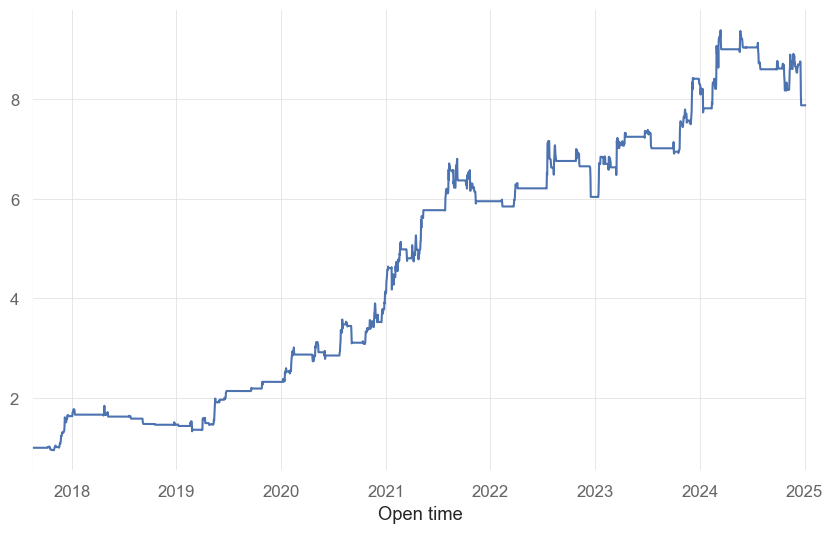

In [85]:
# Entry: The highest high of the last 30 days.
# Exit: After 3 days on the close.

entries = _high.rolling(30).max() == _high
exits = entries.shift(3).fillna(False)

pf = vbt.Portfolio.from_signals(_close, 
                                entries, 
                                exits,
                                fees=0.001)

pf.returns().mean(axis=1).add(1).cumprod().plot()


### Trend Catcher

Long Rules:

- Regime Filter: BTC > MA50 
- Entry: Daily candle crosses above MA20
- Exit: Close below MA20
- Multiple Entries: Prioritize the coin with the highest liquidity the last 4 weeks
- Money Management: Max 20 positions, 5% of capital per trade

Short Rules:

- Regime Filter: BTC < MA50
- Entry: Daily candle crosses below MA20
- Exit: Close above MA20
- Multiple Entries: Prioritize the coin with highest liquidity the last 4 weeks
- Money Management: Max 20 positions, 5% of capital per trade

https://www.robuxio.com/wp-content/uploads/TrendCatcher.pdf

<Axes: xlabel='Open time'>

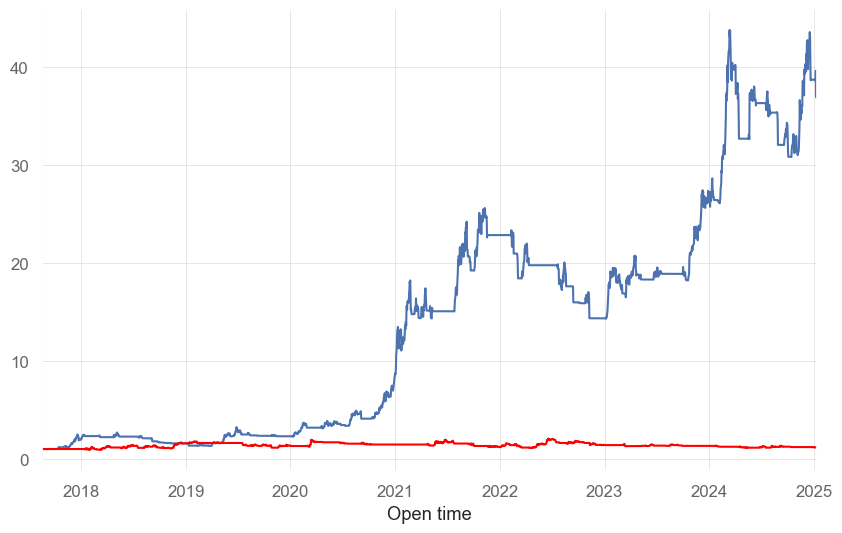

In [110]:
# Long TC

regime_filter = _close['BTCUSDT'] > _close['BTCUSDT'].rolling(50).mean().shift()
regime_filter = pd.DataFrame(np.repeat(regime_filter.values.reshape(-1,1), len(_close.columns), axis=1), 
            index=regime_filter.index, 
            columns=_close.columns)

entries = (_close.shift() > _close.rolling(20).mean().shift()) & regime_filter
exits = (_close.shift() < _close.rolling(20).mean().shift()) | ~regime_filter

pf = vbt.Portfolio.from_signals(_close.loc[entries.index],
                               entries,
                               exits, 
                               fees=0.001)

pf.returns().mean(axis=1).add(1).cumprod().plot()

# Short TC

regime_filter = _close['BTCUSDT'] < _close['BTCUSDT'].rolling(50).mean().shift()
regime_filter = pd.DataFrame(np.repeat(regime_filter.values.reshape(-1,1), len(_close.columns), axis=1), 
            index=regime_filter.index, 
            columns=_close.columns)

short_entries = (_close.shift() < _close.rolling(20).mean().shift()) & regime_filter
short_exits = (_close.shift() > _close.rolling(20).mean().shift()) | ~regime_filter

pf = vbt.Portfolio.from_signals(_close.loc[short_entries.index],
                               short_entries=short_entries,
                               short_exits=short_exits, 
                               fees=0.001)

pf.returns().mean(axis=1).add(1).cumprod().plot(color='red')



In [102]:
regime_filter

Open time
2017-08-17 00:00:00+00:00    False
2017-08-18 00:00:00+00:00    False
2017-08-19 00:00:00+00:00    False
2017-08-20 00:00:00+00:00    False
2017-08-21 00:00:00+00:00    False
                             ...  
2025-01-07 00:00:00+00:00     True
2025-01-08 00:00:00+00:00    False
2025-01-09 00:00:00+00:00    False
2025-01-10 00:00:00+00:00    False
2025-01-11 00:00:00+00:00    False
Freq: D, Name: BTCUSDT, Length: 2705, dtype: bool

symbol,BTCUSDT,ETHUSDT
Open time,,
2017-08-17 00:00:00+00:00,False,False
2017-08-18 00:00:00+00:00,False,False
2017-08-19 00:00:00+00:00,False,False
2017-08-20 00:00:00+00:00,False,False
2017-08-21 00:00:00+00:00,False,False
...,...,...
2025-01-07 00:00:00+00:00,True,True
2025-01-08 00:00:00+00:00,False,False
2025-01-09 00:00:00+00:00,False,False


,2017-08-17 00:00:00+00:00,2017-08-18 00:00:00+00:00,2017-08-19 00:00:00+00:00,2017-08-20 00:00:00+00:00,2017-08-21 00:00:00+00:00,2017-08-22 00:00:00+00:00,2017-08-23 00:00:00+00:00,2017-08-24 00:00:00+00:00,2017-08-25 00:00:00+00:00,2017-08-26 00:00:00+00:00,...,2025-01-04 00:00:00+00:00,2025-01-05 00:00:00+00:00,2025-01-06 00:00:00+00:00,2025-01-07 00:00:00+00:00,2025-01-08 00:00:00+00:00,2025-01-09 00:00:00+00:00,2025-01-10 00:00:00+00:00,2025-01-11 00:00:00+00:00,BTCUSDT,ETHUSDT
Open time,,,,,,,,,,,,,,,,,,,,,
2017-08-17 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-08-18 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-08-19 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-08-20 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2017-08-21 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2025-01-08 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2025-01-09 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
